Challenge Questions<br>
1. How many deliveries took more than 45 minutes?<br>
2. How many deliveries were made in less than 20 minutes?<br>
3. Identify orders where the customer phone number is missing. How many such instances are there? Also why is this a problem for the business?<br>
4. What is the most common payment method for orders that took more than 45 minutes to deliver?<br>
5. What is the average delivery fee for orders that took more than 30 minutes?<br>
6. How many orders took more than 45 minutes to deliver and also had a delivery fee of more than $5?<br>
7. Does the pizza size affect the delivery time? Calculate the average delivery time for each pizza size.<br>
8. Create your own question and answer it.<br>
9. Bonus:, Create a dashboard to showcase your insights to management

% dependencies

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sql

% read csv

In [2]:
df = pd.read_csv('../../data/pizza_delivery.csv')
df.head()

,order_id,customer_name,customer_phone,customer_address,pizza_size,pizza_toppings,order_date,delivery_time,delivery_fee,payment_method,order_total,order_status,driver_rating,delivery_duration
0,1,Garold Artois,602-814-3850,36219 Helena Road,large,pepperoni,10/28/2020,56,9.02,cash,45.85,in progress,4.4,77
1,2,Wini Ellaway,NaN,93865 Oxford Parkway,small,onions,11/13/2020,21,4.94,credit card,13.11,delivered,4.7,91
2,3,Ingar Jocelyn,922-575-1373,8 Stuart Parkway,medium,pepperoni,2/1/2021,38,7.49,credit card,25.54,pending,2.0,117
3,4,Derron Ambrosetti,905-836-6939,5 Golf Course Avenue,medium,peppers,5/22/2020,26,0.74,cash,32.76,in progress,1.8,52
4,5,Murial Laidlaw,438-772-0006,50 Norway Maple Trail,medium,pepperoni,7/20/2020,29,1.43,credit card,41.66,delivered,3.2,87


% number of rows

In [3]:
df.shape[0]

1000

% create engine and connection

In [4]:
engine = sql.create_engine('sqlite:///pizza')
connection = engine.connect()
df.to_sql('pizza', con=connection)

1000

% get metadata and create table

In [6]:
metadata = sql.MetaData()
pizza = sql.Table('pizza', metadata, autoload_with=engine)
print(repr(pizza))
print(metadata.tables.keys())

Table('pizza', MetaData(), Column('index', BIGINT(), table=<pizza>), Column('order_id', BIGINT(), table=<pizza>), Column('customer_name', TEXT(), table=<pizza>), Column('customer_phone', TEXT(), table=<pizza>), Column('customer_address', TEXT(), table=<pizza>), Column('pizza_size', TEXT(), table=<pizza>), Column('pizza_toppings', TEXT(), table=<pizza>), Column('order_date', TEXT(), table=<pizza>), Column('delivery_time', BIGINT(), table=<pizza>), Column('delivery_fee', FLOAT(), table=<pizza>), Column('payment_method', TEXT(), table=<pizza>), Column('order_total', FLOAT(), table=<pizza>), Column('order_status', TEXT(), table=<pizza>), Column('driver_rating', FLOAT(), table=<pizza>), Column('delivery_duration', BIGINT(), table=<pizza>), schema=None)
dict_keys(['pizza'])


% inspector object

In [7]:
inspector = sql.inspect(engine)
cols = []

In [8]:
for i in range(df.shape[1]):
    cols.append({inspector.get_columns('pizza')[i]['name']:inspector.get_columns('pizza')[i]['type']})

% eda<br>
deliveries that took more than 45 minutes

In [9]:
stmt = sql.select(sql.func.count(pizza.columns.order_id))
stmt = stmt.where(pizza.columns.delivery_time > 45)
print(f"Total orders with delivery time over 45 minutes: {connection.execute(stmt).scalar()}")

Total orders with delivery time over 45 minutes: 250


%<br>
deliveries that took less than 20 minutes

In [10]:
stmt = sql.select(sql.func.count(pizza.columns.order_id))
stmt = stmt.where(pizza.columns.delivery_time < 20)
print(f"Total orders with delivery time less than 20 minutes: {connection.execute(stmt).scalar()}")

Total orders with delivery time less than 20 minutes: 193


%<br>
customers with no phone number

In [11]:
stmt = sql.select(sql.func.count(pizza.columns.order_id))
stmt = stmt.where(pizza.columns.customer_phone == None)
print(f"Customers that didn't input there phone number: {connection.execute(stmt).scalar()}")
print("Business cannot contact the customers of more than third of their orders.")

Customers that didn't input there phone number: 350
Business cannot contact the customers of more than third of their orders.


%<br>
most common payment type for orders that took more than 30 minutes

In [12]:
stmt = sql.select(pizza.columns.payment_method, sql.func.count(pizza.columns.order_id))
stmt = stmt.group_by(pizza.columns.payment_method)
stmt = stmt.where(pizza.columns.delivery_time > 30)
print(connection.execute(stmt).fetchall())

[('cash', 178), ('credit card', 197), ('online payment', 198)]


%<br>
What is the average delivery fee for orders that took more than 30 minutes?

In [13]:
stmt = sql.select(sql.func.avg(pizza.columns.delivery_fee))
stmt = stmt.where(pizza.columns.delivery_time > 30)
print(f"Average delivery fee for orders over 30 minutes: {connection.execute(stmt).scalar()}")

Average delivery fee for orders over 30 minutes: 5.082356020942408


%<br>
How many orders took more than 45 minutes to deliver and also had a delivery fee of more than $5?

In [14]:
stmt = sql.select(sql.func.count(pizza.columns.order_id))
stmt = stmt.where(sql.and_(pizza.columns.delivery_time > 45,
                           pizza.columns.delivery_fee > 5))
print(f"Orders that took more than 45 minutes and are more than $5: {connection.execute(stmt).scalar()}")

Orders that took more than 45 minutes and are more than $5: 126


% <br>
Does the pizza size affect the delivery time? Calculate the average delivery time for each pizza size.

In [15]:
stmt = sql.select(pizza.columns.pizza_size, 
                  sql.func.avg(pizza.columns.delivery_time))
stmt = stmt.group_by(pizza.columns.pizza_size)
print(f"Mean delivery time for each pizza size: {connection.execute(stmt).fetchall()}")

Mean delivery time for each pizza size: [('large', 34.17901234567901), ('medium', 34.19452887537994), ('small', 33.99135446685879)]


% bivariate analysis<br>
Create question and answer it<br>
Is there a correlation between delivery_time and driver_rating

It seems like there is no correlation/pattern between these two variables.


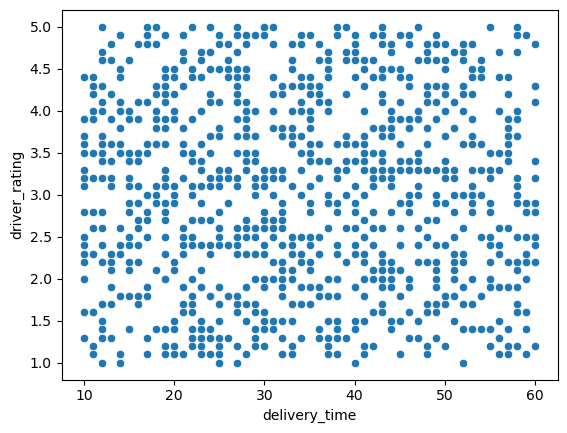

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 1, figsize=(12, 7))
fig = sns.scatterplot(data=df,
                x='delivery_time',
                y='driver_rating')
fig = fig.get_figure()
print("It seems like there is no correlation/pattern between these two variables.")
plt.show()
fig.savefig("corr.png")

% dashboard?

In [2]:
# from flask import Flask
# from flask_sqlalchemy import SQLAlchemy

In [ ]:
# class Config(object):
#     SQLALCHEMY_DATABASE_URL = 'sqlite:///pizza'
#     SQLALCHEMY_TRACK_MODIFICATIONS = False
    
# db = SQLAlchemy()

In [ ]:
# def create_app():
#     server = Flask(__name__)
#     server.config.from_object(Config)
#     db.init_app(server)
    
#     with server.app_content():
#         df = pd.read_csv('pizza_delivery.csv')
#         df.to_sql('pizza', con=db.engine, if_exists='replace')
        
#     from .dashboard import create_dashapp
#     dash_app = create_dashapp(server)
#     return server